# Pretrained Networks

In deze oefening gaan we werken met een dataset waarbij geprobeerd wordt om te detecteren welke delen op een foto overstroomd zijn.
Deze informatie kan dan gebruikt worden om hulpdiensten aan te sturen of bestuur te sturen om gericht hulp te verlenen en prioriteiten te stellen.

Hiervoor gebruik je [deze dataset](https://www.kaggle.com/datasets/sovitrath/flood-segmentation-dataset-trainvalidation-split).

In deze opdracht ga je gebruik maken van een segmentation pretrained network van [tensorflow hub](https://tfhub.dev/s?module-type=image-segmentation).

Schrijf in de code cellen hieronder de nodige code om de volgende stappen op te stellen:

* Toon een aantal beelden en segmentaties
* Voer data augmentation uit
* Toon enkele varianten van een figuur
* Bouw het model: data augmentation plus een pre-trained variant. Bekijk de outputs van het model. Komt dit overeen met de labels uit de dataset? Indien nee, zorg dat je het kan oplossen. 
* Voer predicties uit en toon de resultaten

Beantwoord daarna/ondertussen/eerst de volgende vragen:
* Welk model heb je gekozen?
* Op welke data is dit model getrained?
* Wat zijn de input- en outputdimensies?
* Moet je iets aanpassen aan het model om segmentatie voor flood detection uit te kunnen voeren.
* Welke soorten lagen worden gebruikt in dit model. Als er 1 aanwezig is die niet 1 van de standaard lagen is (Convolutional, Pooling, BatchNormalization, Flatten, Dense), zoek uit wat ze doet en leg het hier uit.
* Maak je gebruik van transfer-learning, fine-tuning of geen training in dit voorbeeld. Verklaar je antwoord.
* Bespreek de behaalde resultaten. Werkt het model goed of merk je veel fouten op?

Tips:
* Indien je een hub-model gebruikt ipv een KerasLayer: je kan het toevoegen aan een sequentieel model door het te verpakken in een custom layer (overerving)
* Gebruik bij de predict enkel de images van de eerste batch. Haal ze uit de dataset zoals gezien in de les.
* Let goed op de dimensies van wat het model verwacht, output en wat je verwacht als output om te plotten

De evaluatie voor deze oefening is:
* 40% code-correctheid/volledigheid
* 20% code netheid en kwaliteit
* 40% antwoorden op de vragen

**Antwoord:** ...

In [2]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import opendatasets as od
import cv2

In [2]:
# downloaden data/model
od.download('https://www.kaggle.com/datasets/sovitrath/flood-segmentation-dataset-trainvalidation-split')

Skipping, found downloaded files in ".\flood-segmentation-dataset-trainvalidation-split" (use force=True to force download)


In [3]:
# inlezen data
TRAIN_IMAGE_PATH = ".\\flood-segmentation-dataset-trainvalidation-split\\flood-area-segmentation\\train_images"
TRAIN_MASK_PATH = ".\\flood-segmentation-dataset-trainvalidation-split\\flood-area-segmentation\\train_masks"
VAL_IMAGE_PATH = ".\\flood-segmentation-dataset-trainvalidation-split\\flood-area-segmentation\\valid_images"
VAL_MASK_PATH = ".\\flood-segmentation-dataset-trainvalidation-split\\flood-area-segmentation\\valid_masks"

BATCH_SIZE = 1
VAL_SPLIT = 0.2
IMG_HEIGHT = 512
IMG_WIDTH = 512

train_ds = tf.data.Dataset.list_files(TRAIN_IMAGE_PATH + '/*.jpg', seed=123)  
val_ds = tf.data.Dataset.list_files(VAL_IMAGE_PATH + '/*.jpg', seed=123)

# get label from path
def get_label(file_path):  
  # Replace the image file extension with .txt to get the label file path    
  file_path = tf.strings.regex_replace(file_path, 'images', 'masks')
  file_path = tf.strings.regex_replace(file_path, '.jpg', '.png')
  target = tf.io.read_file(file_path)
  target =  tf.io.decode_png(target)
  target = tf.image.resize(target, [IMG_HEIGHT, IMG_WIDTH])
  return target

# lees img from file
def decode_img(img):

  img = tf.io.read_file(img) 
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

# hoe ga je van path naar tensors
def process_path(file_path):
  return decode_img(file_path), get_label(file_path)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)

def configure_for_performance(ds):
  ds = ds.batch(BATCH_SIZE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [4]:
# toon een aantal figuren
def plot_images_with_segmentations(ds, batch_number=0, num_figures=4, predictions=None):
    # Get the batch data
    img_batch, label_batch = next(iter(ds.skip(batch_number).take(1)))
    
    num_cols = 2 if predictions is None else 3

    fig, axs = plt.subplots(num_figures, num_cols, figsize=(3 * num_cols, 3 * num_figures))
        
    for i in range(num_figures):
        img = img_batch[i]
        label = label_batch[i]

        # Convert TensorFlow tensors to NumPy arrays
        img = img.numpy() / 255.
        label = label.numpy()
        print(label.sum())
        
        # Plot the image
        axs[i, 0].imshow(img)
        
        # Plot the label
        axs[i, 1].imshow(label)
        
        # Plot predictions if available
        if predictions is not None:
            pred = predictions[i+ batch_number*BATCH_SIZE]
            pred = tf.math.round(pred)
            print(tf.reduce_sum(pred))
            axs[i, 2].imshow(pred)
        
    plt.show()

In [8]:
# data augmentation
preprocessor = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    tf.keras.layers.RandomBrightness(0.001)         # why not flip or rotate the image
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


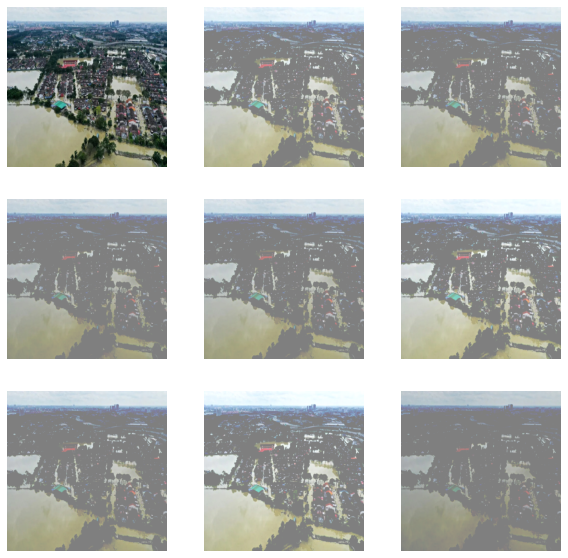

In [9]:
# toon een aantal varianten van een figuur
def draw_figures(data_augmentation, image):
    
    tmp = tf.cast(tf.expand_dims(image, 0), tf.float32)
   
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        if i > 0:
            augmented_image = data_augmentation(tmp)
            plt.imshow(augmented_image[0] / 2.0 + 0.5)
        else:
            plt.imshow(image/255.0)
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
draw_figures(preprocessor, image_batch[0])

In [10]:
# bouw het model
keras_layer = hub.KerasLayer('https://www.kaggle.com/models/google/autoseg-edgetpu/frameworks/TensorFlow2/variations/default-argmax-s/versions/1')
base_model = tf.keras.Sequential([keras_layer])
base_model.build([None, IMG_WIDTH, IMG_HEIGHT, 3])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
# Make a prediction using the first image in the list of images.
image_batch, mask_batch = next(iter(train_ds.take(1)))
print(image_batch.shape)
print(mask_batch.shape)
pred_mask = base_model.predict(image_batch)
 
# The predicted mask has the following shape: [B, H, W, C].
print('Shape of predicted mask: ', pred_mask.shape)

(1, 512, 512, 3)
(1, 512, 512, 1)
1/1 [==============================] - 2s 2s/step
Shape of predicted mask:  (1, 512, 512)


In [55]:
flood_model = tf.keras.models.Sequential([
    preprocessor,       # rescaling and random brightness
    base_model,         # pretrained model
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),   # add dimension to the end of pred_mask
    tf.keras.layers.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")
])

pred_mask = flood_model.predict(image_batch)
 
# The predicted mask has the following shape: [B, H, W, C].
print('Shape of predicted mask: ', pred_mask.shape)

1/1 [==============================] - 2s 2s/step
Shape of predicted mask:  (1, 512, 512, 1)


In [56]:
# train indien nodig het model
checkpoint_file = 'flood_detection.h5'

flood_model.compile(optimizer="rmsprop", loss="binary_crossentropy")
flood_model.fit(train_ds, epochs=10, validation_data = val_ds)

Epoch 1/10


257/257 [==============================] - 233s 896ms/step - loss: 2418.5232 - val_loss: 2240.8977
Epoch 2/10
257/257 [==============================] - 228s 889ms/step - loss: 2084.7295 - val_loss: 1917.1913
Epoch 3/10
257/257 [==============================] - 219s 853ms/step - loss: 1765.0430 - val_loss: 1596.2072
Epoch 4/10
257/257 [==============================] - 227s 884ms/step - loss: 1456.7491 - val_loss: 1278.2247
Epoch 5/10
257/257 [==============================] - 227s 884ms/step - loss: 1128.0708 - val_loss: 957.2638
Epoch 6/10
257/257 [==============================] - 227s 883ms/step - loss: 815.8807 - val_loss: 639.5725
Epoch 7/10
257/257 [==============================] - 205s 799ms/step - loss: 494.3750 - val_loss: 316.5792
Epoch 8/10
257/257 [==============================] - 207s 806ms/step - loss: 165.8910 - val_loss: -4.4582
Epoch 9/10
257/257 [==============================] - 202s 787ms/step - loss: -151.2284 - val_loss: -325.1474
Epoch 10/10
257/257 [========

In [42]:
# maak de voorspellingen voor de eerste batch
predictions= flood_model.predict(image_batch)
predictions.shape
predictions

1/1 [==============================] - 2s 2s/step


array([[[[2.1036896e-01],
         [2.1036896e-01],
         [2.1036896e-01],
         ...,
         [2.0462414e-04],
         [2.0462414e-04],
         [2.0462414e-04]],

        [[2.1036896e-01],
         [2.1036896e-01],
         [2.1036896e-01],
         ...,
         [2.0462414e-04],
         [2.0462414e-04],
         [2.0462414e-04]],

        [[2.1036896e-01],
         [2.1036896e-01],
         [2.1036896e-01],
         ...,
         [2.0462414e-04],
         [2.0462414e-04],
         [2.0462414e-04]],

        ...,

        [[1.2200969e-06],
         [1.2200969e-06],
         [1.2200969e-06],
         ...,
         [1.2200969e-06],
         [1.2200969e-06],
         [1.2200969e-06]],

        [[1.2200969e-06],
         [1.2200969e-06],
         [1.2200969e-06],
         ...,
         [1.2200969e-06],
         [1.2200969e-06],
         [1.2200969e-06]],

        [[1.2200969e-06],
         [1.2200969e-06],
         [1.2200969e-06],
         ...,
         [1.2200969e-06],
        

43033.89
tf.Tensor(0.0, shape=(), dtype=float32)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

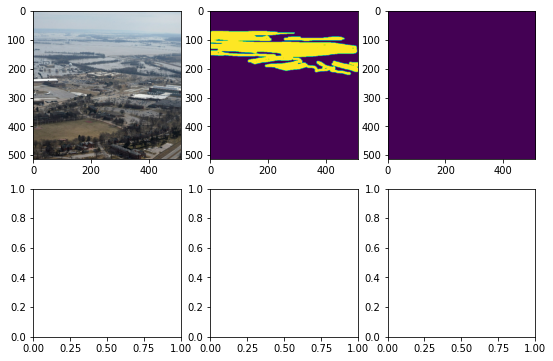

In [45]:
# toon de voorspellingen
plot_images_with_segmentations(train_ds, batch_number=0, num_figures=2, predictions=predictions)

In [47]:
predictions.round().sum()

3317.0

In [48]:
3317/150/150

0.14742222222222223